<a href="https://colab.research.google.com/github/yuvrav/ipynb_playground/blob/master/ace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!pip install "/content/drive/My Drive/Neural_shared/SDK/firefly-0.0.13.tar.gz"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing ./drive/My Drive/Neural_shared/SDK/firefly-0.0.13.tar.gz
  Created wheel for firefly: filename=firefly-0.0.13-cp36-none-any.whl size=10364 sha256=0487ad56327e13f80230b7b14564ef391c3ec11804cbab518ca8ef8646f531ec
  Stored in directory: /root/.cache/pip/wheels/2f/8a/31/484215ecab81f68cb742c0617f6e9b58abad8f82e1f3266e76
Successfully built firefly
  Found existing installation: firefly 0.0.13
    Uninstalling firefly-0.0.13:
      Successfully uninstalled firefly-0.0.13


In [0]:
PATH="/content/drive/My Drive/Neural_shared/customers/ace/"
data_name="Populus_Firefly_Data"

In [0]:
import firefly
import pandas as pd
import numpy as np
import getpass

In [0]:
# USER = input("User:")
# PASSWORD = getpass.getpass("Password:")
USER="fakici@acecashexpress.com"
PASSWORD="AceCash#1"

try:
    ffclient = firefly.Client(username=USER, password=PASSWORD)
except Exception as e:
    print(e)

In [0]:
df = pd.read_csv(PATH+data_name+".csv")

In [0]:
df

,LNAPPID,STATE,COMPANY,MODELID,SUM_LOAN_COUNT_HIST,APPDATE,ISPAYDAY,ISINSTALL,ISFUNDED,ISDUE,ISDUEFIRSTPAYMENT,ISSTUCK,ISSTUCKFIRSTPAYMENT,CF60,CF90,CF180,FT_V10,AADM11,LINKC007,AT31S,LINKC034,LTA3901,LTA3978,G202A,APPS_7DAYS,SCORE_VALUE,LINKC031,CUSTAGE,LTA3856,ZIPCODESALLTIME,AT103S,APPS_24HRS,AT34A,G980S,DDACOUNT,CELLPHONES0_30,FIN_INQUIRIES,APPLICATION_SOURCE_LO,MEDIUM_TRANS_LO,PAYMETHOD_LO,PAYDAY_LO,N_PREV_ADDR_LEN,PREV_ADDR_LEN,N_NUM_NEW_LOAN_ORIG,NUM_NEW_LOAN_ORIG,N_MT47S,MT47S,N_G215A,G215A,N_RP01S,RP01S,N_AU51A,AU51A,N_BANK_ACCTS_ALL,BANK_ACCTS_ALL,N_DEROG_RCD_CNT,DEROG_RCD_CNT,N_LTA3968,LTA3968,N_LTA3845,LTA3845,N_LINKC006,LINKC006,N_ADDR_COUNT,ADDR_COUNT,N_LTA3001,LTA3001,N_RE102S,RE102S,N_LTA3002,LTA3002,N_BR20S,BR20S,N_BC104S,BC104S,BAD60,G3_PD
0,15127447,OH,C06,610,0,20180301,1,0,0,0,0,0,0,0.00,0.00,0.00,624,523,4,1,-99,3,0,1,1,560,-99,35,1.0000,2,100,1,1,4,4,1,1,-1.041,-0.564,-1.083,-0.952,107.0,107.0,1,1,-1,-1,-4,-4,0,0,72,72,5,5,6.0,6.0,0.6471,0.6471,1.0000,0.6000,3,3,4.0,4.0,10.0,10.0,400,400,11.0,11.0,1,1,88,88,NaN,0.71287
1,15427932,TX,CI5,610,0,20180420,0,1,0,0,0,0,0,0.00,0.00,0.00,586,582,9,1,5,5,5,-3,2,569,3,47,9.9998,1,100,2,1,1,1,1,1,-1.041,-0.184,-1.083,-1.404,11.0,11.0,0,4,-1,-1,1,1,0,0,-1,-1,1,1,0.0,0.0,0.0769,0.0769,9.9998,0.6000,3,3,1.0,1.0,4.0,4.0,-1,-1,6.0,6.0,-1,-1,-1,-1,NaN,0.53465
2,15442092,MN,I01,610,0,20180423,1,0,1,1,0,1,0,92.68,92.68,92.68,607,562,-99,-4,-99,5,5,-4,3,546,-99,28,9.9998,2,-4,3,-4,0,3,1,0,-1.041,-0.184,-1.083,-0.952,41.0,41.0,0,4,-4,-1,1,1,-4,-4,-4,-4,3,3,4.0,4.0,1.0000,1.0000,9.9998,0.6000,0,0,3.0,3.0,0.0,0.0,-4,-4,1.0,1.0,-4,-4,-4,-4,0.0,0.48515
3,15263169,CA,I01,610,0,20180326,1,0,1,1,0,1,0,-82.51,-82.51,-67.51,599,579,4,1,-99,2,1,1,0,566,-99,26,1.0000,3,100,0,1,4,2,0,1,-1.041,-1.069,-1.083,-0.995,20.0,20.0,18,7,-1,-1,-4,-4,0,0,54,54,3,3,0.0,0.0,0.4000,0.4000,0.4000,0.4000,2,2,2.0,2.0,9.0,9.0,225,225,16.0,16.0,27,27,150,150,1.0,0.52475
4,15490213,CA,I01,610,1,20180430,1,0,1,1,0,0,0,44.08,-240.00,-240.00,568,545,4,1,-99,2,1,-3,0,554,-99,30,9.9998,2,100,0,1,3,2,1,1,-1.041,-0.998,-1.083,-1.404,60.0,60.0,7,7,-1,-1,6,6,0,0,73,72,3,3,0.0,0.0,0.4167,0.4167,0.0000,0.5000,2,2,2.0,2.0,3.0,3.0,-3,-3,10.0,10.0,-1,-1,-3,-3,0.0,0.61386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15482715,TX,CI5,610,1,20180428,0,1,1,0,1,0,1,83.77,-131.78,-131.78,617,535,5,-99,4,0,3,-3,0,530,-99,28,9.9998,1,100,0,1,4,2,0,1,-1.041,-1.372,-1.083,-0.952,-1.0,10.0,3,3,-1,-1,2,2,0,0,66,66,2,2,0.0,0.0,0.4545,0.4545,0.0000,0.5000,0,0,1.0,1.0,3.0,3.0,-3,-3,5.0,5.0,28,28,-3,-3,0.0,0.61386
996,15693318,CA,I01,610,0,20180523,1,0,0,0,0,0,0,0.00,0.00,0.00,612,593,7,1,4,2,0,1,0,587,4,49,1.0000,3,100,0,1,9,2,1,1,-1.149,-1.069,-1.083,-0.897,53.0,53.0,1,1,-1,-1,-4,-4,0,0,72,72,3,3,2.0,2.0,0.0000,0.0000,0.2208,0.2208,7,7,3.0,3.0,20.0,20.0,1189,1189,32.0,32.0,68,68,49,49,NaN,0.57426
997,15737839,CA,I01,610,0,20180528,1,0,0,0,0,0,0,0.00,0.00,0.00,567,580,4,1,2,3,0,1,0,577,1,35,1.0000,2,100,0,1,4,3,1,1,-1.041,-1.069,-1.083,-0.897,205.0,205.0,1,1,-1,-1,-4,-4,0,0,72,72,4,4,0.0,0.0,0.1429,0.1429,0.6000,0.6000,2,2,2.0,2.0,5.0,5.0,560,560,10.0,10.0,15,15,101,101,NaN,0.61386
998,15583036,CA,I01,610,0,20180510,1,0,0,0,0,0,0,0.00,0.00,0.00,628,576,10,1,-99,2,1,-2,0,584,-99,36,9.9996,0,100,0,1,0,0,0,0,-1.041,-1.372,-0.805,-0.952,177.0,177.0,0,4,-1,-1,2,2,0,0,36,36,0,0,1.0,1.0,0.1765,0.1765,0.0000,0.5000,0,0,0.0,0.0,1.0,1.0,-2,-2,2.0,2.0,-1,-1,-1,-1,NaN,0.49505


In [0]:
df_no_nan = df[(df.BAD60==0)|(df.BAD60==1)]

In [0]:
df_no_nan.shape

(249, 77)

In [0]:
source_id=ffclient.upload_df(df=df_no_nan, data_source_name=data_name, wait=True, skip_if_exists=True)

In [0]:
source_id


4370

In [0]:
dataset_id = ffclient.prepare_data(data_id=source_id, dataset_name=data_name,
                      problem_type='classification',
                      header=True,
                      target='BAD60',
                      retype_columns={'BAD60':'categorical'},
                      sample_id=['LNAPPID'],
                      wait=True, skip_if_exists=True)

In [0]:
simple_estimators=ffclient.get_available_configuration_options(presets={'interpretable': 2}, dataset_id=dataset_id)['estimators']
all_estimators=ffclient.get_available_configuration_options(presets={'interpretable': 0}, dataset_id=dataset_id)['estimators']
simple_pipeline=ffclient.get_available_configuration_options(presets={'interpretable': 2}, dataset_id=dataset_id)['pipeline']
simple_pipeline, simple_estimators,all_estimators

(['data_cleaning_pre_imputation',
  'text_preprocessing',
  'imputation',
  'data_cleaning_post_imputation',
  'auto_sample_generation',
  'balancing',
  'feature_selection',
  'estimator'],
 ['decision_tree', 'logreg', 'ridge_classification'],
 ['random_forest',
  'xgradient_boosting',
  'adaboost',
  'extra_trees',
  'k_nearest_neighbors',
  'passive_aggressive',
  'proj_logit',
  'bernoulli_nb',
  'nn_keras_sequential',
  'anomaly_gmm',
  'anomaly_isof',
  'anomaly_hist',
  'decision_tree',
  'gaussian_nb',
  'gradient_boosting',
  'sgd',
  'qda',
  'multinomial_nb',
  'logreg',
  'libsvm_svc',
  'lda',
  'liblinear_svc',
  'ridge_classification',
  'light_gradient_boosting',
  'cat_boost',
  'complement_nb'])

In [0]:
n_samples = df_no_nan.shape[0]
n_folds=5
train_size=0.80
test_size=0.20
validation_size=1/n_folds # 20%

task_id = ffclient.train(
                name=data_name+" LR",
                target_metric='auc',
                estimators=['logreg'],
                dataset_id=dataset_id,
                splitting_strategy='stratified',
                notes='Explainable Logistic Regression Leakage',
                interpretability_level=2, pipeline=simple_pipeline,
                validation_strategy='cv',
                n_folds=5, test_size=test_size, train_size=train_size,
                validation_size=validation_size, 
                timeout=5*60,
                wait=True, skip_if_exists=True
            )

In [0]:
# task_id=ffclient.get_tasks_by_name('Populus_Firefly_Data LR')[0]['id']
# ensemble_id=ffclient.get_task_record(task_id)['ensemble_id']


# ffclient.get_task_result(task_id)

In [0]:
# ffclient.get_model_sensitivity_report(ensemble_id=ensemble_id)


In [0]:
from  scipy.stats import pearsonr

In [0]:
CFx = [c  for c in df_no_nan.columns if c.startswith("CF") ]



In [0]:
for c in CFx:
  print("pearson for {} is {}".format(c,pearsonr(df_no_nan[c], df_no_nan.BAD60)))

pearson for CF60 is (-0.7825979154714673, 9.282782911068323e-53)
pearson for CF90 is (-0.605422608818354, 2.70859032787284e-26)
pearson for CF180 is (-0.5237426851518927, 6.08929498068675e-19)


In [0]:
#create a data set without the CF

In [0]:
dataset_id_cfx = ffclient.prepare_data(
                      data_id=source_id, 
                      dataset_name=data_name+" no CFx",
                      problem_type='classification',
                      header=True,
                      target='BAD60',
                      retype_columns={'BAD60':'categorical'},
                      sample_id=['LNAPPID'],
                      not_used=CFx,
                      wait=True, skip_if_exists=True)

In [0]:
n_samples = df_no_nan.shape[0]
n_folds=5
train_size=0.80
test_size=0.20
validation_size=1/n_folds

task_id = ffclient.train(
                name=data_name+" DT",
                target_metric='auc',
                estimators=['decision_tree'],
                dataset_id=dataset_id_cfx,
                splitting_strategy='stratified',
                notes='Explainable Decision Tree',
                interpretability_level=2, pipeline=simple_pipeline,
                validation_strategy='cv',
                n_folds=n_folds, test_size=test_size, train_size=train_size,
                validation_size=validation_size, 
                timeout=5*60, ensemble_size=1,
                wait=True, skip_if_exists=True
            )




In [0]:
task_id = ffclient.train(
                name=data_name+" LR",
                target_metric='auc',
                estimators=['logreg'],
                dataset_id=dataset_id_cfx,
                splitting_strategy='stratified',
                notes='Explainable Logistic Regression',
                interpretability_level=2, pipeline=simple_pipeline,
                validation_strategy='cv',
                n_folds=n_folds, test_size=test_size, train_size=train_size,
                validation_size=validation_size, 
                timeout=5*60, ensemble_size=1,
                wait=True, skip_if_exists=True
            )

In [0]:
n_samples = df_no_nan.shape[0]
n_folds=10
train_size=0.80
test_size=0.20
validation_size=1/n_folds


task_id = ffclient.train(
                name=data_name+" prc10",
                target_metric='auc',
                estimators=all_estimators,
                dataset_id=dataset_id_cfx,
                splitting_strategy='stratified',
                notes='Precision',
                interpretability_level=0, 
                validation_strategy='cv',
                n_folds=n_folds, test_size=test_size, train_size=train_size,
                validation_size=validation_size, 
                timeout=60*60, ensemble_size=5,
                wait=True, skip_if_exists=True
            )

KeyboardInterrupt: ignored

In [0]:
n_samples = df_no_nan.shape[0]
n_folds=10
train_size=0.80
test_size=0.20
validation_size=1/n_folds


task_id = ffclient.train(
                name=data_name+" nn",
                target_metric='auc',
                estimators=['nn_keras_sequential'],
                dataset_id=dataset_id_cfx,
                splitting_strategy='stratified',
                notes='Precision NN',
                interpretability_level=0, 
                validation_strategy='cv',
                n_folds=n_folds, test_size=test_size, train_size=train_size,
                validation_size=validation_size, 
                timeout=5*60*60, ensemble_size=5,
                wait=True, skip_if_exists=True
            )

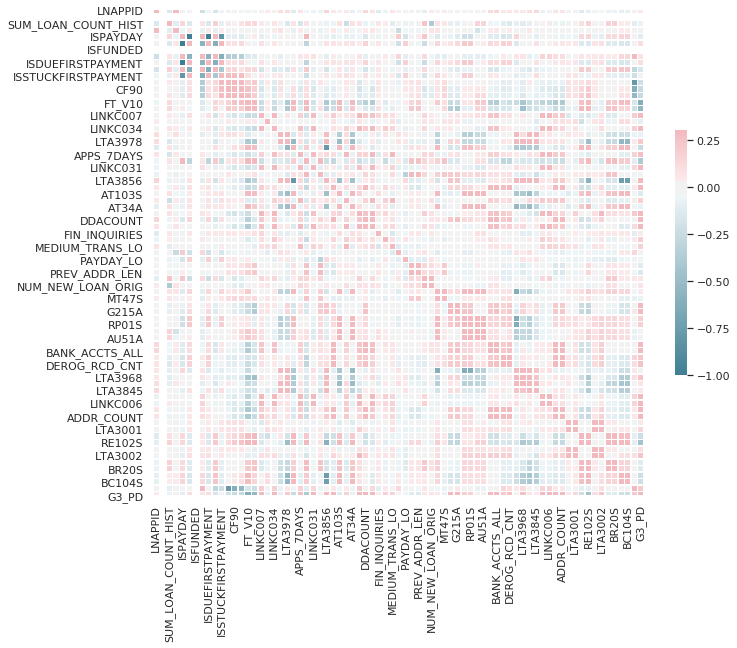

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df_no_nan.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
# inventory
datasources = ffclient.list_datasources(search_all_columns=data_name)['hits']
datasets = ffclient.list_datasets(search_all_columns=data_name)['hits']
tasks = ffclient.list_tasks(search_all_columns=data_name)['hits']

print("Found {} data sources, {} datasets, {} tasks with name {}".format(len(datasources), len(datasets), len(tasks), data_name))

Found 1 data sources, 2 datasets, 3 tasks with name Populus_Firefly_Data


In [0]:
sure=input("Input 'Y' for deleting demo files and tasks:")

if sure=='Y':

  for d in datasources:
    ffclient.delete_datasource(d['id'])

  for d in datasets:
    ffclient.delete_dataset(d['id'])

  for d in tasks:
    ffclient.delete_task(d['id'])

KeyboardInterrupt: ignored